In [40]:
!pip install 'tritonclient[http]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.1/873.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.6 MB/s eta 0:00:00a 0:00:01


In [ ]:
!curl http://localhost:8000/v2/models

In [41]:
import tritonclient.http as httpclient
import numpy as np

client = httpclient.InferenceServerClient(url="34.44.52.194:8000")

input_data = httpclient.InferInput("prompt", [1], "BYTES")
input_data.set_data_from_numpy(np.array(["파리는 어떤 나라의 수도야?"], dtype=object))

results = client.infer(
    model_name="vllm_model",  # 실제 등록된 모델 이름
    inputs=[input_data]
)

output = results.as_numpy("completion")[0]
print(output.decode())


InferenceServerException: [501] HTTP end point doesn't support models with decoupled transaction policy

In [2]:
from pydantic import BaseModel
from typing import List, Dict, Optional, Any, Annotated
from pprint import pprint
from collections import defaultdict

# langgraph 정의
from langgraph.graph import StateGraph
from langchain_teddynote.graphs import visualize_graph
from langsmith import traceable
from unidiff import PatchSet

from openai import AsyncOpenAI

import json

In [3]:
with open("dataset_mvp_runs.jsonl", "r" ,encoding= 'utf-8') as f:
    data_mvp = [json.loads(line) for line in f]


In [4]:
data_mvp[146]["inputs"]["input"]

{'date': '2025-03-11',
 'repo': '943724054',
 'files': [{'patches': [{'patch': '@@ -19,4 +19,4 @@ RUN echo "DATABASE_URL=${DATABASE_URL}" > .env\n EXPOSE 8000\n \n # 7. FastAPI 실행 명령\n-CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8000"]\n\\ No newline at end of file\n+CMD alembic upgrade head && uvicorn main:app --host 0.0.0.0 --port 8000\n\\ No newline at end of file',
     'commit_message': 'feat: 데이터 베이스 업데이트 추가'}],
   'filepath': 'Dockerfile',
   'latest_code': '# 1. Python 3.10 이미지 사용\nFROM python:3.10\n\n# 2. 작업 디렉토리 설정\n# WORKDIR /app\n\n# 3. 종속성 파일 복사 후 패키지 설치\nCOPY requirements.txt .\nRUN pip install --no-cache-dir -r requirements.txt\n\n# 4. 애플리케이션 코드 복사\nCOPY . .\n\n# 5. GitHub Actions에서 환경 변수를 받아 `.env` 파일로 저장\nARG DATABASE_URL\nRUN echo "DATABASE_URL=${DATABASE_URL}" > .env\n\n# 6. 컨테이너에서 실행할 포트 설정\nEXPOSE 8000\n\n# 7. FastAPI 실행 명령\nCMD alembic upgrade head && uvicorn main:app --host 0.0.0.0 --port 8000'},
  {'patches': [{'patch': '@@ -48,6 +48,5 @@ htmlcov

## Schema 정의

In [5]:
#===========Json Schema===========#
class CodeSummaryModel(BaseModel):
    code_summary: str
    # check_important_change: str

#================================#

def merge_dicts(x: dict, y: dict) -> dict:
    if x is None:
        return y
    if y is None:
        return x
    return {**x, **y}

# patches 내부 형식 정의
class PatchModel(BaseModel):
    patch: str
    commit_message: str

# files 내부 형식 정의
class FilesModel(BaseModel):
    patches: List[PatchModel]
    filepath: str
    latest_code: str

class DirectoryModel(BaseModel):
    patches: List[PatchModel]
    latest_code: str
    filepath: str
    directory_summary: Optional[str] = None
    code_summary: str = None
    file_node_id: Optional[int] = None  # 파일 단위 node ID

class DirectoryGroupModel(BaseModel):
    directory_node_id: Optional[int] = None  # 디렉토리 단위 node ID
    files: Dict[str, DirectoryModel]
    directory_summary: Optional[str] = None

class TilModel(BaseModel):
    username: str
    repo: str
    date: str
    keywords: List[str]
    til_content: Optional[str]  = None 

# Input 형식 정의
class GraphState(BaseModel):
    username: str
    category: Optional[str] = None
    repo: str
    date: str
    files: List[FilesModel]
    til_content: Optional[str]  = None 

    directory_dict:  Annotated[Optional[Dict[str, DirectoryGroupModel]], merge_dicts] = None
    

input_data = GraphState(**data_mvp[146]["inputs"]["input"]) # ** 연산자를 사용하여 딕셔너리를 키워드 인자로 전달

## 디렉토리 구조로 변환

In [6]:
def make_directory(state: GraphState) -> GraphState:
    repo_prefix = state.repo
    grouped_by_directory = defaultdict(dict)

    for file in state.files:
        dir_path = "/".join(file.filepath.split("/")[:-1])
        normalized_dir = f"{repo_prefix}/{dir_path}" if dir_path else repo_prefix

        grouped_by_directory[normalized_dir][file.filepath] = DirectoryModel(
            filepath=file.filepath,
            latest_code=file.latest_code,
            patches=file.patches
        )

    state.directory_dict = {
        k: DirectoryGroupModel(files=v) for k, v in grouped_by_directory.items()
    }
    return state

input_data = make_directory(input_data)

## 코드 변경 사항 반영

In [7]:
def annotate_code_with_patch(latest_code: str, patch_text: str, filename: str) -> str:
    # 유효한 patch 헤더 붙이기
    if not patch_text.startswith('--- '):
        patch_text = f"--- a/{filename}\n+++ b/{filename}\n" + patch_text

    patch = PatchSet(patch_text)
    code_lines = latest_code.splitlines()
    annotated = code_lines.copy()

    target_file = next((f for f in patch if f.path == filename or f.path.endswith(filename)), None)
    if not target_file:
        return latest_code  # 변경 없음

    offset = 0
    for hunk in target_file:
        for line in hunk:
            if line.is_added and line.target_line_no is not None:
                idx = line.target_line_no - 1
                # 줄 내용이 동일하면 주석만 덧붙이기
                if idx < len(annotated) and annotated[idx].strip() == line.value.strip():
                    annotated[idx] = "[+]" + annotated[idx].rstrip()  
                else:
                    # 삽입이 필요한 경우에만 insert
                    annotated.insert(idx,"[+]" + line.value.rstrip())
                offset += 1
            # 삭제된 줄도 표시
            elif line.is_removed:
                idx = line.source_line_no - 1 + offset
                annotated.insert(idx, f"[-] {line.value.rstrip()}")
                offset += 1

    return "\n".join(annotated)

## 디렉토리 구조 시각화

In [8]:
# 예시 input_data
filepaths = [data.filepath for data in input_data.files]
# 디렉토리 기준으로 그룹화
grouped_by_directory = defaultdict(list)
for path in filepaths:
    dir_path = "/".join(path.split("/")[:-1])  # 상위 디렉토리 경로만 추출
    grouped_by_directory[dir_path].append(path)

# 출력
directory_structure = ""
directory_list = []
for directory, files in grouped_by_directory.items():
    directory_structure += f"📂 {directory}\n"
    for f in files:
        directory_structure += f"  └── {f}\n"
        directory_list.append(f)
print(directory_structure)

📂 
  └── Dockerfile
  └── .gitignore
  └── alembic.ini
  └── main.py
📂 alembic/versions
  └── alembic/versions/c49e19c13dfb_updated_schema.py



## 디렉토리 분류 노드

In [9]:
updated_directory_dict = {}
file_counter = 1
directory_counter = 1

# 디렉토리 경로 순회 (입력 순서 유지)
for dir_path in input_data.directory_dict:
    group_model = input_data.directory_dict[dir_path]
    updated_files = {}

    # 파일 경로 순회 (입력 순서 유지)
    for filepath in group_model.files:
        file_model = group_model.files[filepath]
        updated_file_model = file_model.model_copy(update={"file_node_id": file_counter})
        updated_files[filepath] = updated_file_model
        file_counter += 1

    updated_group_model = group_model.model_copy(update={
        "files": updated_files,
        "directory_node_id": directory_counter
    })
    updated_directory_dict[dir_path] = updated_group_model
    directory_counter += 1

In [10]:
dir_keys = list(updated_directory_dict.keys())

updated_directory_dict[dir_keys[1]].files["alembic/versions/c49e19c13dfb_updated_schema.py"].file_node_id

5

In [11]:
## dictionary의 items() 메소드는 순서를 보장하지 않음

# 디렉토리 구분 없이 file 번호 지정
@traceable(run_type="tool")
def fork_directory_nodes(state: GraphState) -> GraphState:
    updated_directory_dict = {}
    file_counter = 1
    directory_counter = 1

    # 디렉토리 경로 순회 (입력 순서 유지)
    for dir_path in state.directory_dict:
        group_model = state.directory_dict[dir_path]
        updated_files = {}

        # 파일 경로 순회 (입력 순서 유지)
        for filepath in group_model.files:
            file_model = group_model.files[filepath]
            updated_file_model = file_model.model_copy(update={"file_node_id": file_counter})
            updated_files[filepath] = updated_file_model
            file_counter += 1

        updated_group_model = group_model.model_copy(update={
            "files": updated_files,
            "directory_node_id": directory_counter
        })
        updated_directory_dict[dir_path] = updated_group_model
        directory_counter += 1

    return {"directory_dict": updated_directory_dict}

## 파일 단위 Summary

In [12]:
client = AsyncOpenAI(
            base_url="http://34.44.52.194:8000/v1", 
            api_key="sk-noauth")

In [14]:
def code_summary_prompt(latest_code:str, language=None):
    return f"""
        당신은 {language} 코드 분석 전문가입니다. 다음의 내용을 숙지하여 항목에 맞는 코드 요약을 수행해주세요.
       다음은 소스코드의 변경 내용입니다. 각 코드 라인의 앞에 [+]는 추가된 줄, [-]는 삭제된 줄을 의미합니다.

        [변경된 소스 코드]
        {latest_code}

        요약 항목:
        - 사용 기술 스택: 언어 및 사용된 주요 라이브러리
        - 주요 기능: 이 코드 파일의 기능을 한 줄씩 나열
        - 프로젝트 내 역할: 전체 시스템에서 이 파일이 담당하는 역할
        - 변경 내용 요약: 이번 코드 변경을 통해 **무엇이 어떻게 바뀌었는지** 핵심만 요약

        ⚠️ 출력 조건:
        - 각 항목은 반드시 `-`로 시작하는 개조식 문장으로 작성할 것
        - 변경 내용도 `-` 하나씩 줄바꿈하여 작성할 것
        - 문장은 간결하게 유지하고, 불필요한 설명은 포함하지 말 것
        - 자연어 설명이 아니라 **기능 단위의 요점 중심 요약**으로 작성할 것
        
        요약:"""

In [15]:
def directory_summary_prompt(code_summary:str, category:str, directory:str):
    return f"""
    당신은 {category}의 코드 리뷰어입니다. 다음은 디렉토리(`{directory}`) 내 여러 파일에 걸쳐 적용된 코드 변경 요약입니다.

    [디렉토리 내부 코드 요약 내용]
    {code_summary}

    [제약 조건]
    - 동일한 목적의 중복 기능은 통합하여 요약합니다.
    - 기술 스택은 주요 구현 언어 또는 프레임워크 단위로 간단히 정리합니다.

    [요약 항목]
    - 사용 기술 스택: 이 디렉토리에서 사용된 언어 및 주요 라이브러리
    - 주요 기능: 사용자 관점에서 이 디렉토리가 제공하는 기능을 한 줄씩 개조식으로 작성
    - 시스템 내 역할: 이 디렉토리가 전체 프로젝트 내에서 담당하는 책임 또는 기능적 포지션
    - 변경 목적 요약: 이번 코드 변경의 전반적인 목적, 개선 방향 또는 핵심 의도

    [출력 형식]
    각 항목은 반드시 `-`로 시작하는 개조식 문장으로 작성하세요.  
    설명형 서술은 지양하고, **핵심적인 기능 단위의 명확한 요약**을 작성해 주세요.
        
    요약:"""

In [16]:
def til_generate_prompt(date:str, combined_directory_summary: str):
    return  f"""
다음은 하나 이상의 소스코드 파일에 대한 분석 요약과 변경 이력 분석입니다. 이를 참고하여 마크다운 형식의 TIL을 작성해 주세요.

[날짜]
{date}

[코드 + 변경 요약]
{combined_directory_summary}

⚠️ 출력 규칙:
- 각 줄은 절대 들여쓰기 없이 시작하세요.
- 헤더는 `#`, `##`로 시작하고 공백 없이 맨 앞에 위치해야 합니다.
- 본문도 줄 맨 앞에서 시작해야 하며, 불필요한 공백이나 탭을 포함하지 마세요.
- 마크다운 문법 이외의 코드블록(````), 따옴표(`"`, `'`) 블록 등은 사용하지 마세요.
        

TIL 작성 시 반드시 포함할 항목 (개조식):
제목: # 📅 날짜 TIL
### 📖 1. 오늘 배운 내용

### 📚 2. 개념 정리

### 🤔 3. 해당 개념이 필요한 이유

### 💡 4. 개념을 활용하는 방법

### 🛠️ 5. 문제 해결 과정

### ✍️ 6. 하루 회고

작성 시 포함해야 할 항목 외에는 작성하지 마세요. 1번 항목부터 순차적으로 작성하세요. 들여쓰기는 없어야 합니다.
        
TIL:"""

combined_summary = ""

In [17]:
def make_code_summary_node(file_node_id: int):
    @traceable(run_type="llm")
    async def summarize_file_node(state: GraphState) -> dict:
        print(file_node_id)
        # file_node_id에 해당하는 grouped_model, filepath, directory 찾기
        for directory, file_group in state.directory_dict.items():
            for filepath, grouped_model in file_group.files.items():
                if grouped_model.file_node_id == file_node_id:
                    target_model = grouped_model
                    target_filepath = filepath
                    target_directory = directory
                    break
            else:
                continue
            break
        else:
            raise ValueError(f"file_node_id {file_node_id}에 해당하는 파일이 없습니다.")
        
        latest_code = annotate_code_with_patch(latest_code=target_model.latest_code,
                                               patch_text=target_model.patches[0].patch, 
                                               filename=target_model.filepath)
        # LLM 요청
        messages = [{
            "role": "user",
            "content": code_summary_prompt(latest_code=latest_code, language=None)
        }]
        

        request_payload = {
            "model": "google/gemma-3-4b-it",
            "messages": messages,
            "temperature": 0.1,
            "max_tokens": 512,
            "top_p": 0.95,
            "stop": ['<|im_end|>']
        }


        response = await client.chat.completions.create(**request_payload)
        summary = response.choices[0].message.content
        original_model = state.directory_dict[target_directory].files[target_filepath]
        updated_model = original_model.model_copy(update={"code_summary": summary})
        state.directory_dict[target_directory].files[target_filepath] = updated_model

        return {"directory_dict":state.directory_dict}

    return summarize_file_node

## 디렉토리 분석 노드

In [18]:
for directory, file_group in input_data.directory_dict.items():
    # if file_group.directory_node_id == directory_node_id:
    target_directory = directory
    group_model =  file_group

for filename, dict_model in group_model.files.items():
    print(dict_model.code_summary)

None


In [19]:
def make_directory_summary_node(directory_node_id: int):
    @traceable(run_type="llm")
    async def summarize_directory_node(state: GraphState) -> dict:
        # file_node_id에 해당하는 grouped_model, filepath, directory 찾기
        combined_code_summary = ""
        for directory, file_group in state.directory_dict.items():
            if file_group.directory_node_id == directory_node_id:
                    target_directory = directory
                    group_model =  file_group
                    break
            else:
                continue
        else:
            raise ValueError(f"file_node_id {directory_node_id}에 해당하는 파일이 없습니다.")
        
        for filename, dict_model in group_model.files.items():
            combined_code_summary += f"{filename} code: \n{dict_model.code_summary}"


        # LLM 요청
        messages = [{
            "role": "user",
            "content": directory_summary_prompt(code_summary=combined_code_summary, category=None, directory=target_directory)
        }]
        request_payload = {
            "model": "google/gemma-3-4b-it",
            "messages": messages,
            "temperature": 0.1,
            "max_tokens": 512,
            "top_p": 0.95,
            "stop": ['<|im_end|>']
        }


        response = await client.chat.completions.create(**request_payload)
        # 결과 파싱 (예: structured JSON 반환한다고 가정)

        ## 기존 grouped_model
        original_model = state.directory_dict[target_directory]
        # code_summary 필드 업데이트
        updated_model = original_model.model_copy(update={"directory_summary": response.choices[0].message.content})
        # 상태 반영
        state.directory_dict[target_directory] = updated_model
        return {
            "directory_dict":state.directory_dict
        }

    return summarize_directory_node

## TIL 생성 노드

In [20]:
async def generate_til_node(state: GraphState) -> dict:
    dir_file = state.directory_dict
    combined_directory_summary = ""
    
    for dir_name, group_model in dir_file.items():
        combined_directory_summary += f"{dir_name}: \n directory_summary: {group_model.directory_summary}\n\n"

    # LLM 요청
    messages = [{
        "role": "user",
        "content": til_generate_prompt(date=state.date, combined_directory_summary=combined_directory_summary)
    }]
    request_payload = {
        "model": "google/gemma-3-4b-it",
        "messages": messages,
        "temperature": 0.1,
        "max_tokens": 2024,
        "top_p": 0.95,
        "stop": ['<|im_end|>']
    }


    response = await client.chat.completions.create(**request_payload)
    # 결과 파싱 (예: structured JSON 반환한다고 가정)

    ## 기존 grouped_model
    original_model = state.directory_dict
    # code_summary 필드 업데이트
    updated_model = original_model["til_content"] = response.choices[0].message.content
    # 상태 반영

    til_dict = {
        "username": state.username,
        "repo": state.repo,
        "date": state.date,
        "keywords": [],
        "til_content": response.choices[0].message.content
    }
    return_model = TilModel(**til_dict)
    return return_model
    

## LangGraph 빌드

In [21]:
file_counter = 1
dir_counter = 1

builder = StateGraph(GraphState)
builder.set_entry_point("fork_directory_node")
builder.add_node("fork_directory_node", fork_directory_nodes)
builder.add_node("til_generate_node", generate_til_node)
builder.set_finish_point("til_generate_node")

# 디렉토리 요약 노드 ID 저장용 리스트
dir_node_ids = []

for dir_idx, (dir_path, group_model) in enumerate(input_data.directory_dict.items()):
    # 디렉토리 내 파일 노드 추가
    for file_idx, file_model in enumerate(group_model.files):
        file_path = file_model  # file_model이 str인 경우
        file_node_id = f"summarize_file_node_{file_path.replace('/', '_')}"
        file_summary_node = make_code_summary_node(file_counter)
        builder.add_node(file_node_id, file_summary_node)
        builder.add_edge("fork_directory_node", file_node_id)
        file_counter += 1

    # 디렉토리 요약 노드 추가
    dir_node_id = f"summarize_directory_node_{dir_path.replace('/', '_')}"
    dir_summary_node = make_directory_summary_node(dir_idx + 1)
    dir_node_ids.append(dir_node_id)

    builder.add_node(dir_node_id, dir_summary_node)

    # 각 파일 요약 노드 → 디렉토리 요약 노드 연결
    for file_model in group_model.files:
        file_node_id = f"summarize_file_node_{file_model.replace('/', '_')}"
        builder.add_edge(file_node_id, dir_node_id)

# 디렉토리 요약 노드 → TIL 생성 노드 연결
for dir_node_id in dir_node_ids:
    builder.add_edge(dir_node_id, "til_generate_node")

graph = builder.compile()

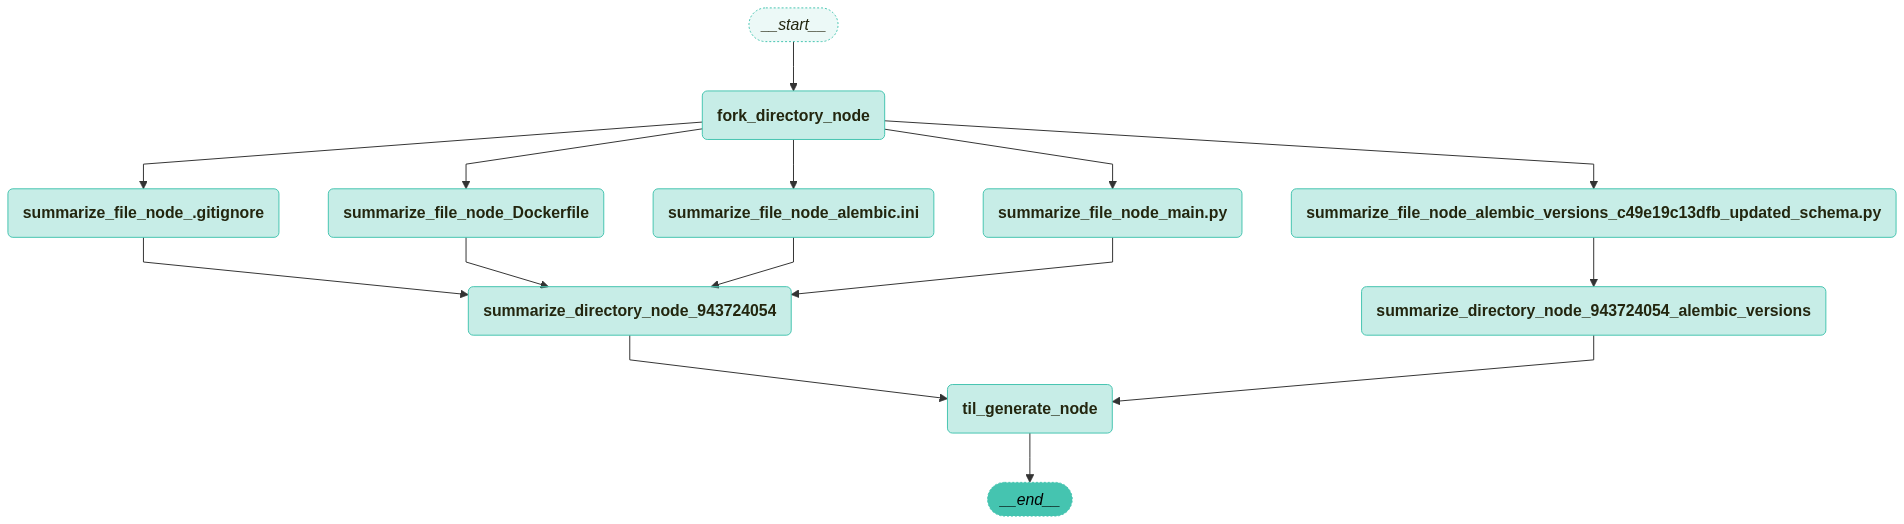

In [22]:
visualize_graph(graph)

In [23]:
result = await graph.ainvoke(input_data)

1
2
3
4
5


NotFoundError: Error code: 404 - {'error': 'Not Found'}

In [118]:
for dir_name, grouped_model in result["directory_dict"].items():
    for file_name, file in grouped_model.files.items():
        print(file.code_summary)
        print("="*100)
    

- 사용 기술 스택: Python 3.10, pip, uvicorn, alembic
- 주요 기능: Docker 이미지 빌드, 종속성 설치, 애플리케이션 코드 복사, 환경 변수 설정, 포트 노출, FastAPI 애플리케이션 실행 (알엠베이스 업그레이드 및 uvicorn 실행)
- 프로젝트 내 역할: FastAPI 애플리케이션을 실행하는 Docker 컨테이너 이미지 정의
- 변경 내용 요약:
    - `CMD` 명령어가 삭제되어 `CMD alembic upgrade head && uvicorn main:app --host 0.0.0.0 --port 8000`으로 변경됨.
    - 환경 변수 `DATABASE_URL`을 `.env` 파일에 저장하는 로직이 추가됨.

- 사용 기술 스택: Python, FastAPI, Uvicorn, Alembic, Pytest, Coverage, MyPy, Pylint, Pyright
- 주요 기능:
    - 가상환경 관리 (venv, .venv)
    - 컴파일된 Python 파일 및 캐시 관리 (__pycache__, *.pyc, *.pyo, *.pyd)
    - 환경 변수 관리 (.env, *.env)
    - 로그 파일 관리 (*.log)
    - 데이터베이스 파일 관리 (*.sqlite3)
    - 프로젝트 인스턴스 폴더 관리 (instance/)
    - IDE 설정 관리 (.vscode/, .idea/, *.iml)
    - Jupyter Notebook 체크포인트 관리 (.ipynb_checkpoints/)
    - OS별 불필요 파일 관리 (.DS_Store, Thumbs.db)
    - FastAPI 및 Uvicorn 실행 관련 파일 관리 (*.pid, *.sock)
    - Docker 설정 관리 (docker-compose.override.yml)
    - 테스트 관련 파일 관리 (.coverage, pytest_cache/, htmlcov/)
    - Linting 관련 파일 관리

In [53]:
for filename, data in result["directory_dict"].items():
    for file in data.files:
        print(data.files[file].file_node_id)

1
2
3
4
5


In [121]:
print(result["til_content"])

# 📅 2025-03-11 TIL

### 📖 1. 오늘 배운 내용
오늘 분석한 코드 변경 이력은 `posts` 테이블에 `author` 컬럼을 추가하고 삭제하는 기능을 구현한 Alembic 마이그레이션 스크립트입니다. `alembic/versions` 디렉토리 내의 `upgrade` 및 `downgrade` 함수가 핵심 역할을 수행합니다. `upgrade` 함수는 새로운 스키마를 적용하고, `downgrade` 함수는 이전 스키마로 되돌립니다.

### 📚 2. 개념 정리
Alembic은 Python 프로젝트에서 데이터베이스 스키마 변경을 관리하는 도구입니다. 마이그레이션 스크립트는 데이터베이스 변경 사항을 추적하고, 변경 사항을 안전하게 적용하거나 되돌릴 수 있도록 합니다. `upgrade` 함수는 새로운 마이그레이션을 적용하고, `downgrade` 함수는 이전 마이그레이션을 취소합니다. SQLAlchemy는 Alembic에서 사용하는 객체 관계 매핑(ORM) 라이브러리입니다.

### 🤔 3. 해당 개념이 필요한 이유
데이터베이스 스키마는 애플리케이션의 핵심 데이터 구조를 정의합니다. 애플리케이션이 발전함에 따라 데이터베이스 스키마도 변경될 수 있습니다. Alembic을 사용하면 이러한 변경 사항을 체계적으로 관리하고, 데이터 손실이나 데이터 불일치 문제를 방지할 수 있습니다. 또한, 변경 사항을 쉽게 되돌릴 수 있어 개발 생산성을 높일 수 있습니다.

### 💡 4. 개념을 활용하는 방법
Alembic을 활용하려면 먼저 Alembic을 프로젝트에 설치하고, 마이그레이션 파일을 생성해야 합니다. 마이그레이션 파일에는 데이터베이스 스키마 변경 사항이 정의됩니다. `upgrade` 함수는 새로운 스키마를 적용하고, `downgrade` 함수는 이전 스키마로 되돌립니다. Alembic은 마이그레이션 파일을 자동으로 실행하여 데이터베이스 스키마를 업데이트합니다.

### 🛠️ 5. 문제 해결 과정
이 코드 분석을 통해 `posts` 테이블에 `author` 컬